# 프로젝트: 폐렴 진단기 성능 개선
## 루브릭
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.

## 1. 실험환경 Set-up

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

데이터를 먼저 로드한다.

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

In [4]:
BATCH_SIZE = 30
EPOCHS = 25

## 2.  데이터 준비하기

In [5]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


validation 데이터의 개수가 너무 적어서 train에서 validation으로 쓰일 데이터를 추가로 가져온다.

In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [7]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0582-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg


경로를 살펴보면 정상/폐렴 여부 데이터를 가지고 있다.

In [8]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


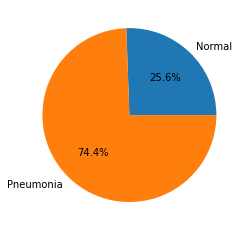

In [9]:
plt.pie([COUNT_NORMAL, COUNT_PNEUMONIA], labels=['Normal', 'Pneumonia'], autopct='%.1f%%')
plt.show()

train 데이터 안 정상과 폐렴의 비율은 폐렴이 74%로 정상데이터보다 3배정도 많아 **imbalance** 하다는 것을 알 수 있다.

tf.data 인스턴스를 만든다.

In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# train, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


라벨 데이터가 따로 없어서 만들어주는 함수를 만든다.

In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


데이터를 효율적으로 할 수 있도록 데이터를 변환시켜준다.
* shuffle() : 고정 크기 버퍼를 유지하고, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
* repeat() : 데이터셋을 여러번 사용할 수 있게 한다.
* batch() : batch_size에서 정한 만큼 배치로 주어진다.
* prefetch() : 학습 데이터를 나눠서 읽어온다.

In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

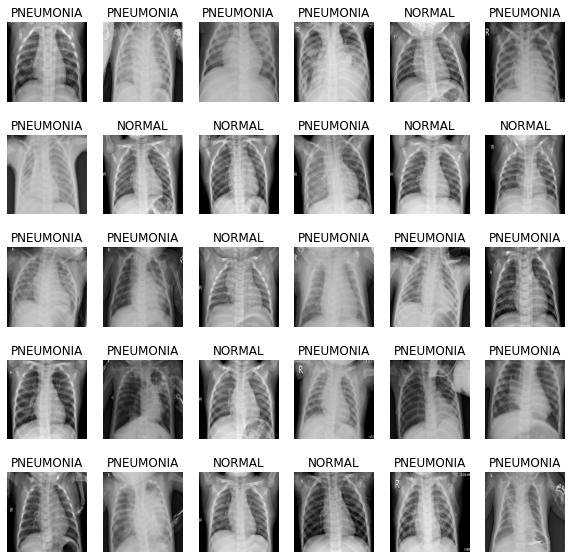

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
139/139 [==============================] - 54s 246ms/step - loss: 0.5254 - accuracy: 0.7282 - precision: 0.9151 - recall: 0.6988 - val_loss: 0.6461 - val_accuracy: 0.7353 - val_precision: 0.7353 - val_recall: 1.0000
Epoch 2/25
139/139 [==============================] - 32s 230ms/step - loss: 0.2028 - accuracy: 0.9292 - precision: 0.9750 - recall: 0.9275 - val_loss: 0.7775 - val_accuracy: 0.7304 - val_precision: 0.7304 - val_recall: 1.0000
Epoch 3/25
139/139 [==============================] - 32s 230ms/step - loss: 0.1806 - accuracy: 0.9424 - precision: 0.9824 - recall: 0.9396 - val_loss: 0.9168 - val_accuracy: 0.7343 - val_precision: 0.7343 - val_recall: 1.0000
Epoch 4/25
139/139 [==============================] - 32s 230ms/step - loss: 0.1504 - accuracy: 0.9481 - precision: 0.9830 - recall: 0.9469 - val_loss: 1.1740 - val_accuracy: 0.7333 - val_precision: 0.7333 - val_recall: 1.0000
Epoch 5/25
139/139 [==============================] - 32s 230ms/step - loss: 0.1296 - accura

## 7. 결과 확인과 시각화

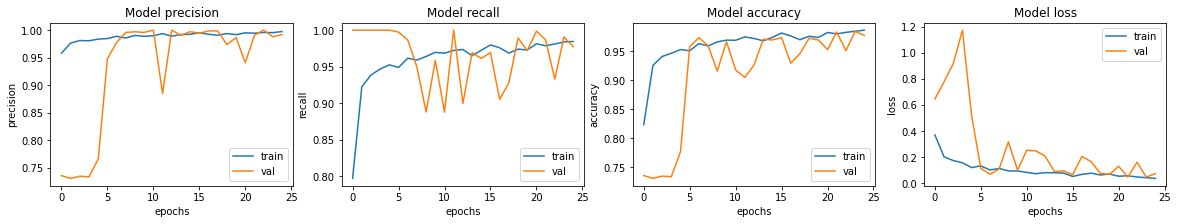

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

21/21 [==============================] - 9s 440ms/step - loss: 1.0892 - accuracy: 0.8045 - precision: 0.7680 - recall: 0.9846
Loss: 1.0891824960708618,
Accuracy: 0.8044871687889099,
Precision: 0.7680000066757202,
Recall: 0.9846153855323792


# 성능 향상 시키기

## 1. 성능 비교

### Normalization과 Dropout 중 Dropout만 사용했을 때

In [26]:
def dense_block_droupout(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### Normalization과 Dropout 중 Normalization만 사용했을 때

In [28]:
def dense_block_normalization(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()        
    ])
    
    return block

### 성능 비교

In [38]:
def build_model_input_dense_block(input_dense_block):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        input_dense_block(512, 0.7),
        input_dense_block(128, 0.5),
        input_dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [41]:
dense = dense_block_droupout
with tf.device('/GPU:0'):
    model = build_model_input_dense_block(dense)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_24 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_25 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_26 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_14 (Dropout)         (None, 11, 11, 128)     

In [42]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    
result = []
evaluate = model.evaluate(test_ds)
result.append(evaluate)
loss, accuracy, precision, recall = evaluate
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/25
139/139 [==============================] - 40s 234ms/step - loss: 0.5316 - accuracy: 0.7017 - precision: 0.8695 - recall: 0.7023 - val_loss: 0.6236 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/25
139/139 [==============================] - 32s 228ms/step - loss: 0.2731 - accuracy: 0.8774 - precision: 0.9733 - recall: 0.8597 - val_loss: 0.9746 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/25
139/139 [==============================] - 32s 228ms/step - loss: 0.1829 - accuracy: 0.9239 - precision: 0.9819 - recall: 0.9134 - val_loss: 1.7065 - val_accuracy: 0.7304 - val_precision: 0.7304 - val_recall: 1.0000
Epoch 4/25
139/139 [==============================] - 32s 228ms/step - loss: 0.1374 - accuracy: 0.9432 - precision: 0.9872 - recall: 0.9361 - val_loss: 2.1617 - val_accuracy: 0.7333 - val_precision: 0.7333 - val_recall: 1.0000
Epoch 5/25
139/139 [==============================] - 32s 228ms/step - loss: 0.1084 - accura

In [43]:
dense = dense_block_normalization
with tf.device('/GPU:0'):
    model = build_model_input_dense_block(dense)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_32 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_33 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_34 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_19 (Dropout)         (None, 11, 11, 128)     

In [49]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    
evaluate = model.evaluate(test_ds)
result.append(evaluate)
loss, accuracy, precision, recall = evaluate
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/25
139/139 [==============================] - 37s 230ms/step - loss: 0.0232 - accuracy: 0.9933 - precision: 0.9987 - recall: 0.9923 - val_loss: 0.1028 - val_accuracy: 0.9676 - val_precision: 0.9945 - val_recall: 0.9613
Epoch 2/25
139/139 [==============================] - 32s 229ms/step - loss: 0.0263 - accuracy: 0.9921 - precision: 0.9971 - recall: 0.9923 - val_loss: 0.1651 - val_accuracy: 0.9559 - val_precision: 0.9958 - val_recall: 0.9441
Epoch 3/25
139/139 [==============================] - 32s 229ms/step - loss: 0.0255 - accuracy: 0.9902 - precision: 0.9971 - recall: 0.9897 - val_loss: 0.0557 - val_accuracy: 0.9794 - val_precision: 0.9815 - val_recall: 0.9906
Epoch 4/25
139/139 [==============================] - 32s 230ms/step - loss: 0.0192 - accuracy: 0.9935 - precision: 0.9977 - recall: 0.9936 - val_loss: 0.1212 - val_accuracy: 0.9608 - val_precision: 0.9986 - val_recall: 0.9479
Epoch 5/25
139/139 [==============================] - 32s 230ms/step - loss: 0.0327 - accura

### 비교

In [50]:
for idx, (loss, accuracy, precision, recall) in enumerate(result): 
    if idx == 0:
        print('dense_block_droupout')
    else:
        print('dense_block_normalization')
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

dense_block_droupout
Loss: 1.034733772277832,
Accuracy: 0.8092948794364929,
Precision: 0.7715430855751038,
Recall: 0.9871794581413269
dense_block_normalization
Loss: 1.9598761796951294,
Accuracy: 0.7532051205635071,
Precision: 0.7177121639251709,
Recall: 0.9974358677864075


dropout과 normalization를 비교했을 때 dropout만 사용한 것이 accuracy가 더 높았다.
****
##### dropout+normalization 사용했을 때 
Loss: 1.0891824960708618,
Accuracy: 0.8044871687889099,
Precision: 0.7680000066757202,
Recall: 0.9846153855323792

이것과 비교해도 dropout만 사용한 것이 조금 더 높은 것을 알 수 있다.

## 2. callback 추가

callback을 추가하는 형태로 다시 모델 훈련을 시킨다.

In [66]:
checkpoint_filepath = '../tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[model_checkpoint_callback, early_stopping],
    )
    
evaluate = model.evaluate(test_ds)
result.append(evaluate)
loss, accuracy, precision, recall = evaluate
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/25
139/139 [==============================] - 41s 251ms/step - loss: 0.0413 - accuracy: 0.9878 - precision: 0.9967 - recall: 0.9868 - val_loss: 0.1032 - val_accuracy: 0.9627 - val_precision: 0.9695 - val_recall: 0.9799
Epoch 2/25
139/139 [==============================] - 35s 251ms/step - loss: 0.0363 - accuracy: 0.9854 - precision: 0.9961 - recall: 0.9842 - val_loss: 0.2971 - val_accuracy: 0.9265 - val_precision: 1.0000 - val_recall: 0.9003
Epoch 3/25
139/139 [==============================] - 35s 253ms/step - loss: 0.0584 - accuracy: 0.9789 - precision: 0.9944 - recall: 0.9772 - val_loss: 0.1489 - val_accuracy: 0.9618 - val_precision: 0.9518 - val_recall: 0.9987
Epoch 4/25
139/139 [==============================] - 35s 253ms/step - loss: 0.0366 - accuracy: 0.9823 - precision: 0.9964 - recall: 0.9797 - val_loss: 0.1887 - val_accuracy: 0.9627 - val_precision: 0.9540 - val_recall: 0.9973
Epoch 5/25
139/139 [==============================] - 34s 246ms/step - loss: 0.0261 - accura

val_accuracy가 계속 높아졌다 낮아졌다를 반복하므로 early stopping을 사용하면 안될것이라 판단해 ModelCheckpoint만 사용하려 한다.

## 3. 가우시안 노이즈 추가를 이용한 data augmentation
의료 데이터의 경우 데이터가 많지 않기 때문에 모델의 정확도가 떨어질 수도 있다. 때문에 노드에서 알려준 가우시안 노이즈를 이용한 data augmentation을 했다. 이미지를 자르는 형식의 augmentation을 하지 않은 이유는 일반적인 x-ray 이미지의 경우 비슷한 형태일 것이라 판단했기 때문이다.(인간의 뼈 모양은 비슷하므로??)

In [67]:
def build_model_input_gausian(input_dense_block):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.GaussianNoise(0.1),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        input_dense_block(512, 0.7),
        input_dense_block(128, 0.5),
        input_dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [68]:
dense = dense_block_droupout
with tf.device('/GPU:0'):
    model = build_model_input_gausian(dense)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_56 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_57 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_58 (Sequential)   (None, 11, 11, 128)     

In [70]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[model_checkpoint_callback],
    )
    
evaluate = model.evaluate(test_ds)
result.append(evaluate)
loss, accuracy, precision, recall = evaluate
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/25
139/139 [==============================] - 40s 249ms/step - loss: 0.0438 - accuracy: 0.9839 - precision: 0.9971 - recall: 0.9813 - val_loss: 0.0541 - val_accuracy: 0.9814 - val_precision: 0.9853 - val_recall: 0.9893
Epoch 2/25
139/139 [==============================] - 35s 251ms/step - loss: 0.0465 - accuracy: 0.9849 - precision: 0.9964 - recall: 0.9833 - val_loss: 0.0559 - val_accuracy: 0.9794 - val_precision: 0.9946 - val_recall: 0.9773
Epoch 3/25
139/139 [==============================] - 35s 253ms/step - loss: 0.0423 - accuracy: 0.9835 - precision: 0.9948 - recall: 0.9829 - val_loss: 0.3110 - val_accuracy: 0.8873 - val_precision: 0.8667 - val_recall: 1.0000
Epoch 4/25
139/139 [==============================] - 34s 243ms/step - loss: 0.0642 - accuracy: 0.9784 - precision: 0.9938 - recall: 0.9771 - val_loss: 0.1519 - val_accuracy: 0.9637 - val_precision: 0.9575 - val_recall: 0.9947
Epoch 5/25
139/139 [==============================] - 32s 234ms/step - loss: 0.0418 - accura

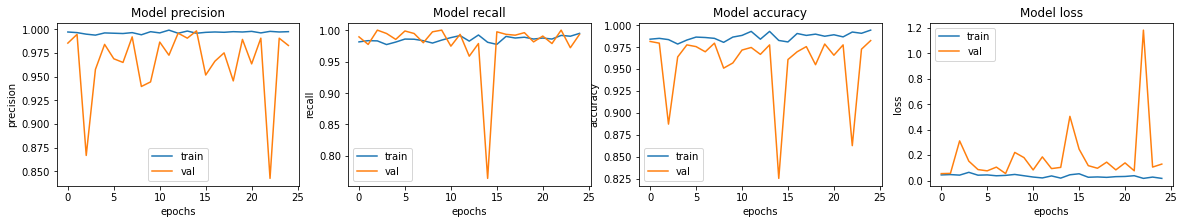

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 원래 모델에 gaussian noise 추가하기

In [72]:
def build_model_gaussian():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.GaussianNoise(0.1),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [74]:
with tf.device('/GPU:0'):
    model = build_model_gaussian()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_64 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_65 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_66 (Sequential)   (None, 11, 11, 128)     

In [75]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[model_checkpoint_callback],
    )
    
evaluate = model.evaluate(test_ds)
result.append(evaluate)
loss, accuracy, precision, recall = evaluate
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/25
139/139 [==============================] - 43s 251ms/step - loss: 0.7792 - accuracy: 0.6010 - precision: 0.8277 - recall: 0.5854 - val_loss: 0.5974 - val_accuracy: 0.7343 - val_precision: 0.7343 - val_recall: 1.0000
Epoch 2/25
139/139 [==============================] - 35s 250ms/step - loss: 0.2976 - accuracy: 0.8759 - precision: 0.9713 - recall: 0.8594 - val_loss: 0.7311 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/25
139/139 [==============================] - 35s 251ms/step - loss: 0.2202 - accuracy: 0.9149 - precision: 0.9786 - recall: 0.9061 - val_loss: 1.2534 - val_accuracy: 0.7284 - val_precision: 0.7284 - val_recall: 1.0000
Epoch 4/25
139/139 [==============================] - 35s 255ms/step - loss: 0.1615 - accuracy: 0.9337 - precision: 0.9819 - recall: 0.9285 - val_loss: 1.8165 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 5/25
139/139 [==============================] - 34s 248ms/step - loss: 0.1502 - accura

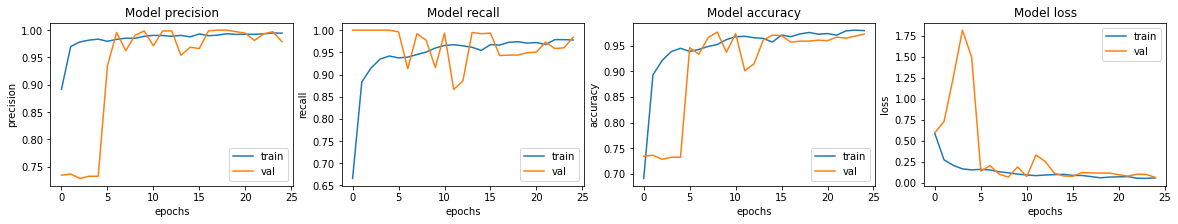

In [76]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 회고

### 알게된점
* data augmentation에는 image crop, image ratate, 밝기 조정 정도 있다고 알고 있었는데 이번에 gaussian noise를 추가하는 것, 채도 조정하는 것이 있다는 것을 알게되었다.
* callback은 한 개만 쓸 것이라 생각했는데 여러개 혼합해서 사용한다는 것을 알게되었다.
* Normalization과 Dropout이 동일하게 regualization한다고 배운 것 같은데 두 개를 섞어서 쓸 수도 있다는 것을 알게되었다.

### 아쉬운점
* 결과를 시각화해보면 그래프의 모양이 평탄한 것이 아니라 들숙날숙한 모양이다. 어떻게 하면 평탄화를 할 수 있는지 찾지를 못했다.
* 성능을 높이려는 작업을 했지만 아쉽게도 기준에 미치지 못했다. 오히려 데이터 증강을 시도했다가 정확도가 떨어졌다.

# Reference

* https://www.tensorflow.org/api_docs/python/tf/keras/layers/GaussianNoise
* https://wikidocs.net/92114
* https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint